# Time series forecasting with statistical models

We want to predict the future values of enrolments and intake of students universities of singapore. Since we have yearly data, we will use statistical models to forecast the future values.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

data_path = 'services/data/processed/annual_student_intake_enrolment.csv'

df = pd.read_csv(data_path)


In [3]:
df["log_intake"] = np.log(df["intake"])

# Centrage de l'année
df["year_centered"] = df["year"] - df["year"].mean()

# Définition des variables
X = df[['year_centered']]
y = df['intake']  # Transformation log

# Ajout d'une constante pour l'intercept
X = sm.add_constant(X)

# Régression OLS
model = sm.OLS(y, X)
results = model.fit()

# Résultats
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 intake   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     142.0
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           1.12e-09
Time:                        16:23:16   Log-Likelihood:                -155.81
No. Observations:                  19   AIC:                             315.6
Df Residuals:                      17   BIC:                             317.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.734e+04    213.799     81.090

c:\Users\theo3\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.
  return hypotest_fun_in(*args, **kwds)


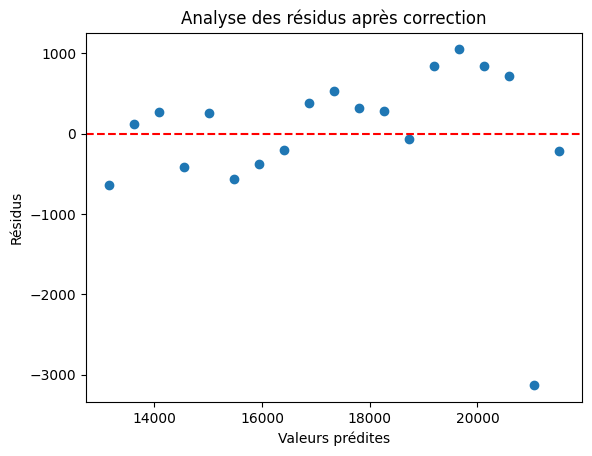

In [4]:
import matplotlib.pyplot as plt

plt.scatter(results.fittedvalues, results.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Analyse des résidus après correction")
plt.show()


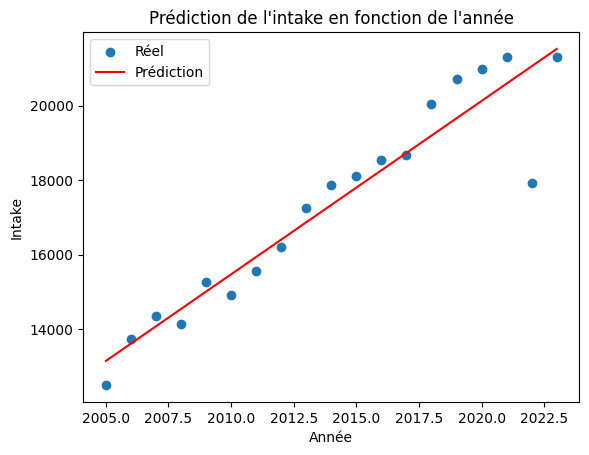

In [5]:
# On plot la prediction par rapport à la réalité pour voir si le modèle est bon

plt.scatter(df["year"], df["intake"], label="Réel")
plt.plot(df["year"], results.fittedvalues, color="red", label="Prédiction")
plt.xlabel("Année")
plt.ylabel("Intake")
plt.title("Prédiction de l'intake en fonction de l'année")
plt.legend()
plt.show()

## Regression quantiles

In [6]:
import statsmodels.formula.api as smf

# Modèle quantile (médiane q=0.5)
model_qr = smf.quantreg('intake ~ year_centered', df).fit(q=0.5)
print(model_qr.summary())


                         QuantReg Regression Results                          
Dep. Variable:                 intake   Pseudo R-squared:               0.7678
Model:                       QuantReg   Bandwidth:                       1123.
Method:                 Least Squares   Sparsity:                        1834.
Date:                Sun, 09 Feb 2025   No. Observations:                   19
Time:                        16:23:19   Df Residuals:                       17
                                        Df Model:                            1
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.76e+04    210.397     83.631      0.000    1.72e+04     1.8e+04
year_centered   530.1667     38.413     13.802      0.000     449.122     611.211


## Transformation boxcox avec regression quantiles

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

data_path = 'services/data/processed/annual_student_intake_enrolment.csv'

df = pd.read_csv(data_path)

In [8]:
from scipy.stats import boxcox

df["intake_boxcox"], lambda_ = boxcox(df["intake"])
print(f"Meilleur lambda pour Box-Cox: {lambda_}")


Meilleur lambda pour Box-Cox: 0.8890933379612012


In [85]:
import statsmodels.formula.api as smf

# Modèle quantile (médiane q=0.5)
model_qr = smf.quantreg('intake_boxcox ~ year', df).fit(q=0.5)
print(model_qr.summary())

                         QuantReg Regression Results                          
Dep. Variable:          intake_boxcox   Pseudo R-squared:               0.7617
Model:                       QuantReg   Bandwidth:                       447.0
Method:                 Least Squares   Sparsity:                        718.9
Date:                Sun, 09 Feb 2025   No. Observations:                   19
Time:                        16:11:39   Df Residuals:                       17
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.221e+05   3.03e+04    -10.623      0.000   -3.86e+05   -2.58e+05
year         163.2617     15.056     10.844      0.000     131.497     195.027

The condition number is large, 7.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


c:\Users\theo3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


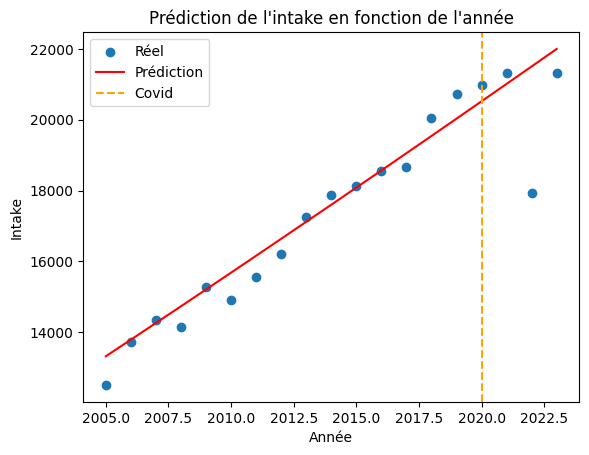

In [86]:
# on print le modèle sur les données de base year et intake

# il faut ramener les predictions à la bonne echelle, car on a fait une transformation Box-Cox sur les données
# Meilleur lambda pour Box-Cox: 0.8890933379612012

# On inverse la transformation Box-Cox
def inverse_boxcox(y, lambda_):
    return np.exp(np.log(lambda_ * y + 1) / lambda_)

# Prédiction
pred_boxcox = model_qr.predict(df)
pred = inverse_boxcox(pred_boxcox, lambda_)

import matplotlib.pyplot as plt

plt.scatter(df["year"], df["intake"], label="Réel")
plt.plot(df["year"], pred, color="red", label="Prédiction")
# On trace une ligne en 2020 pour covid
plt.axvline(x=2020, color="orange", linestyle="--", label="Covid")
plt.xlabel("Année")
plt.ylabel("Intake")
plt.title("Prédiction de l'intake en fonction de l'année")
plt.legend()
plt.show()


## Meme modele pour enrolments

In [89]:
df["enrolment_boxcox"], lambda_ = boxcox(df["enrolment"])
print(f"Meilleur lambda pour Box-Cox: {lambda_}")


Meilleur lambda pour Box-Cox: 0.6301368204093649


In [90]:
import statsmodels.formula.api as smf

# Modèle quantile (médiane q=0.5)
model_qr = smf.quantreg('enrolment_boxcox ~ year', df).fit(q=0.5)
print(model_qr.summary())

                         QuantReg Regression Results                          
Dep. Variable:       enrolment_boxcox   Pseudo R-squared:               0.9399
Model:                       QuantReg   Bandwidth:                       29.82
Method:                 Least Squares   Sparsity:                        48.06
Date:                Sun, 09 Feb 2025   No. Observations:                   19
Time:                        16:13:47   Df Residuals:                       17
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.722e+04   2027.202    -33.157      0.000   -7.15e+04   -6.29e+04
year          34.2032      1.007     33.981      0.000      32.080      36.327

The condition number is large, 7.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


c:\Users\theo3\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


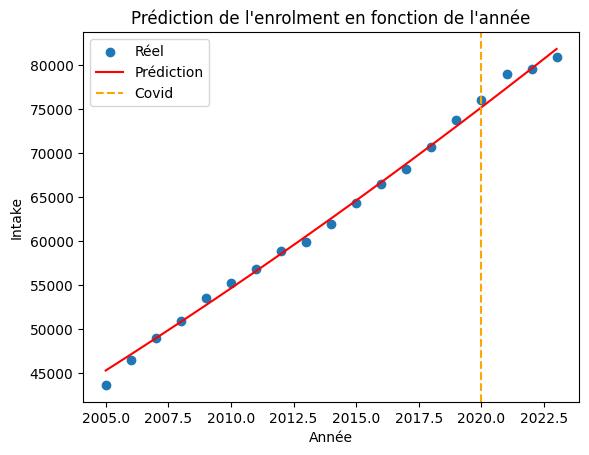

In [92]:
# on print le modèle sur les données de base year et intake

# il faut ramener les predictions à la bonne echelle, car on a fait une transformation Box-Cox sur les données
# Meilleur lambda pour Box-Cox: 0.8890933379612012

# On inverse la transformation Box-Cox
def inverse_boxcox(y, lambda_):
    return np.exp(np.log(lambda_ * y + 1) / lambda_)

# Prédiction
pred_boxcox = model_qr.predict(df)
pred = inverse_boxcox(pred_boxcox, lambda_)

import matplotlib.pyplot as plt

plt.scatter(df["year"], df["enrolment"], label="Réel")
plt.plot(df["year"], pred, color="red", label="Prédiction")
# On trace une ligne en 2020 pour covid
plt.axvline(x=2020, color="orange", linestyle="--", label="Covid")
plt.xlabel("Année")
plt.ylabel("Intake")
plt.title("Prédiction de l'enrolment en fonction de l'année")
plt.legend()
plt.show()
